## Preliminaries

In [76]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro import handlers
from numpyro.handlers import mask
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random
from jax import nn as jnn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score

In [2]:
%matplotlib inline
seed = 1
rng_key = random.PRNGKey(seed)

## Generate dummy data

In [3]:
# Generate items
# For now, items described by single attribute - quality
# Each item has a list price determined by that quality
def gen_items(num_items, rng_key):
    keys = random.split(rng_key,2)
    item_quality = dist.Uniform(1, 10).sample(keys[0], (num_items,))
    list_price = jnp.maximum(dist.Normal(item_quality, 1.0).sample(keys[1]),1.0) * 20
    #plt.scatter(item_quality, list_price)
    return item_quality, list_price

_ = gen_items(100, rng_key)

In [4]:
def lognormal_params(mu, sigma):
    loc = np.log(mu**2/np.sqrt(mu**2 + sigma**2))
    scale = np.sqrt(np.log(1 + sigma**2/mu**2))
    return loc, scale


def gen_cust(num_cust, rng_key):
    keys = random.split(rng_key,3)

    beta_quality_loc = dist.Uniform(5,10).sample(keys[0])
    beta_quality_scale = dist.Uniform(1,2).sample(keys[1])
    loc, scale = lognormal_params(beta_quality_loc, beta_quality_scale)
    beta_quality = dist.LogNormal(loc, scale).expand((num_cust,)).sample(keys[2])
    mean_beta_quality = jnp.mean(beta_quality)
    std_beta_quality = jnp.std(beta_quality)
    print('mean_beta_quality: ' + str(mean_beta_quality), 'std_beta_quality: ' + str(std_beta_quality))

    return beta_quality

_ = gen_cust(10, rng_key)

mean_beta_quality: 7.6662745 std_beta_quality: 0.94968593


In [5]:
def gen_sales(num_sales, rng_key):
    keys = random.split(rng_key,2)
    sales_wtp_bias = dist.Uniform(-0.2,0.1).expand((num_sales,)).sample(keys[0])
    sales_wtp_uncertainty = dist.Uniform(0.1,0.5).expand([num_sales,]).sample(keys[1])
    print('mean_wtp_bias: ' + str(jnp.mean(sales_wtp_bias)), 'std_wtp_bias: ' + str(jnp.std(sales_wtp_bias)))
    print('mean_wtp_uncertainty: ' + str(jnp.mean(sales_wtp_uncertainty)), 'std_wtp_uncertainty: ' + str(jnp.std(sales_wtp_uncertainty)))
    return sales_wtp_bias, sales_wtp_uncertainty

_ = gen_sales(20, rng_key)

mean_wtp_bias: -0.060042 std_wtp_bias: 0.083096355
mean_wtp_uncertainty: 0.34853464 std_wtp_uncertainty: 0.098519154


In [6]:
def gen_quotes(max_items_per_cust, num_cust, num_items, rng_key):
    keys = random.split(rng_key,3)
    concentration = jnp.full(max_items_per_cust, 5.0)
    item_probs = dist.Dirichlet(concentration).sample(keys[0])
    num_item_by_cust = dist.Categorical(item_probs).sample(keys[1], (num_cust,))
    #plt.hist(num_item_by_cust, bins=max_items_per_cust)

    customer_id_list = []
    customer_items_list = []
    key = keys[2]
    for customer, num_items_for_cust in enumerate(num_item_by_cust):
        customer_id_inc = [customer] * num_items_for_cust
        customer_items_inc = random.choice(key, num_items, (num_items_for_cust,), replace=True)
        key = random.split(key,1)[0]
        #customer_items_inc = torch.randperm(num_items)[:num_items_for_cust].tolist()
        customer_id_list.extend(customer_id_inc)
        customer_items_list.extend(customer_items_inc)
        
    customer_id = jnp.array(customer_id_list, dtype=jnp.int32)
    customer_items = jnp.array(customer_items_list, dtype=jnp.int32)
    #print(customer_id.shape, customer_items.shape)

    num_quotes = customer_items.shape[0]
    return customer_id, customer_items, num_quotes

_ = gen_quotes(5, 10, 20, rng_key)

In [7]:
def gen_negotiations(X, rng_key):

    keys = random.split(rng_key,1)

    x_salesperson = jnp.array(X['salesperson'])
    x_item_quality = jnp.array(X['item_quality'])
    x_list_price = jnp.array(X['list_price'])
    x_customer_id = jnp.array(X['customer'])
    x_item = jnp.array(X['item'])
    x_beta_quality = jnp.array(X['beta_quality'])
    x_sales_wtp_bias = jnp.array(X['sales_wtp_bias'])
    x_sales_wtp_uncertainty = jnp.array(X['sales_wtp_uncertainty'])

    num_quotes = len(X)

    y = {}
    key = keys[0]
    for q in range(num_quotes):
        c = x_customer_id[q]
        s = x_salesperson[q]
        i = x_item[q]
        wtp = jnp.minimum(x_item_quality[q] * x_beta_quality[q], x_list_price[q])
        est_wtp = jnp.minimum(dist.Normal(wtp*(1.0+x_sales_wtp_bias[q]), wtp*x_sales_wtp_uncertainty[q]).sample(key), x_list_price[q])
        key = random.split(key,1)[0]
        #print(wtp, x_list_price[q], est_wtp, wtp.dtype, est_wtp.dtype)
        if wtp >= x_list_price[q]:
            result = 1
            price = x_list_price[q]
        if wtp < est_wtp:
            result = 0
            price = np.nan
        else:
            result = 1
            price = ( est_wtp + wtp ) /2
        y[q] = {'result':result, 'price':price, 'wtp':wtp, 'est_wtp':est_wtp}

    return y


In [8]:
def sequential_idx(X):
    # map customer, item and salesperson ids to sequential versions of same for convenience later
    customer_map = {}
    for i, c in enumerate(X['customer'].unique()):
        customer_map[c] = i
    item_map = {}
    for i, item in enumerate(X['item'].unique()):
        item_map[item] = i
    salesperson_map = {}
    for i, s in enumerate(X['salesperson'].unique()):
        salesperson_map[s] = i

    X['customer'] = X['customer'].map(customer_map)
    X['item'] = X['item'].map(item_map)
    X['salesperson'] = X['salesperson'].map(salesperson_map)

    return X

In [30]:
# Generate customers
# Each customer has a view on the value of item quality which determines their willingness to pay

def gen_negs(rng_key):

    keys = random.split(rng_key,6)

    num_items = 100
    item_quality, list_price = gen_items(num_items, keys[0])
    
    num_cust = 10
    beta_quality = gen_cust(num_cust, keys[1])

    # Generate salespeople
    # Each salesperson has an ability to estimate the customers wtp subject to some bias and uncertainty
    num_sales = 10
    sales_wtp_bias, sales_wtp_uncertainty = gen_sales(num_sales, keys[2])

    # Generate quotes
    ## Each customer generates a number of quotes for items
    max_items_per_customer = 100
    customer_id, customer_items, num_quotes = gen_quotes(max_items_per_customer, num_cust, num_items, keys[3])

    ## Salespeople ramdomly assigned to quotes
    salesperson = random.choice(keys[4], num_sales, (num_quotes,), replace=True)

    # Negotiate quotes, get result and agreed price
    X = pd.DataFrame({'customer':customer_id, 'beta_quality':beta_quality[customer_id], 'item':customer_items, 'item_quality':item_quality[customer_items]
        , 'list_price':list_price[customer_items], 'salesperson':salesperson, 'sales_wtp_bias':sales_wtp_bias[salesperson], 'sales_wtp_uncertainty':sales_wtp_uncertainty[salesperson]})

    # map customer, item and salesperson ids to sequential versions of same for convenience later
    X = sequential_idx(X)

    y_dict = gen_negotiations(X, keys[5])
    y = pd.DataFrame.from_dict(y_dict, orient='index', dtype = 'float', columns=['result', 'price', 'wtp', 'est_wtp'])
    
    return pd.concat([X,y], axis=1)


df = gen_negs(rng_key)

mean_beta_quality: 7.4409523 std_beta_quality: 1.4013891
mean_wtp_bias: -0.0719175 std_wtp_bias: 0.07690344
mean_wtp_uncertainty: 0.3066864 std_wtp_uncertainty: 0.096351705


## Profile dummy data

In [31]:
df.describe(include='all')

,customer,beta_quality,item,item_quality,list_price,salesperson,sales_wtp_bias,sales_wtp_uncertainty,result,price,wtp,est_wtp
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,183.000000,319.000000,319.000000
mean,4.830721,6.748823,43.802508,5.405128,108.370422,4.605016,-0.073356,0.300539,0.573668,31.500431,36.538851,35.525924
std,2.395527,1.266671,26.830622,2.651885,56.222378,2.940838,0.075461,0.095210,0.495320,17.777283,19.364644,23.588740
min,0.000000,5.373087,0.000000,1.052650,20.000000,0.000000,-0.199365,0.106068,0.000000,5.051412,6.046823,-6.884666
25%,3.000000,5.744383,20.500000,3.099362,63.435188,2.000000,-0.173425,0.232960,0.000000,17.323700,20.263037,17.049881
50%,5.000000,6.788074,43.000000,5.190859,96.751595,5.000000,-0.048889,0.330438,1.000000,28.381622,34.173927,31.913193
75%,6.000000,7.558427,66.000000,7.596583,152.816422,7.000000,-0.008707,0.378163,1.000000,44.328108,50.833540,47.209366
max,9.000000,10.186422,97.000000,9.922171,239.239471,9.000000,0.014069,0.442296,1.000000,82.641708,91.632561,116.762558


In [32]:
df.sample(10)

,customer,beta_quality,item,item_quality,list_price,salesperson,sales_wtp_bias,sales_wtp_uncertainty,result,price,wtp,est_wtp
171,5,5.373087,47,2.166005,80.809601,5,-0.173425,0.330438,0.0,NaN,11.638131,19.314342
181,5,5.373087,62,3.327330,78.660156,5,-0.173425,0.330438,0.0,NaN,17.878035,20.685181
233,6,5.744383,42,1.052650,21.505428,2,-0.039084,0.332733,1.0,5.051412,6.046823,4.056001
120,5,5.373087,12,6.257621,144.802750,2,-0.039084,0.332733,1.0,24.275871,33.622742,14.929001
34,2,6.400540,27,4.325110,69.401947,4,0.007489,0.378163,0.0,NaN,27.683039,40.868610
174,5,5.373087,27,4.325110,69.401947,7,0.014069,0.366601,1.0,21.483219,23.239191,19.727247
248,6,5.744383,12,6.257621,144.802750,9,-0.079566,0.223597,0.0,NaN,35.946171,36.924397
136,5,5.373087,28,6.339338,110.816040,4,0.007489,0.378163,0.0,NaN,34.061817,34.439526
84,3,6.788074,17,2.874983,67.420143,3,-0.173592,0.442296,0.0,NaN,19.515600,19.977879
36,2,6.400540,29,9.855194,195.796692,4,0.007489,0.378163,0.0,NaN,63.078564,99.030685


<AxesSubplot:ylabel='Frequency'>

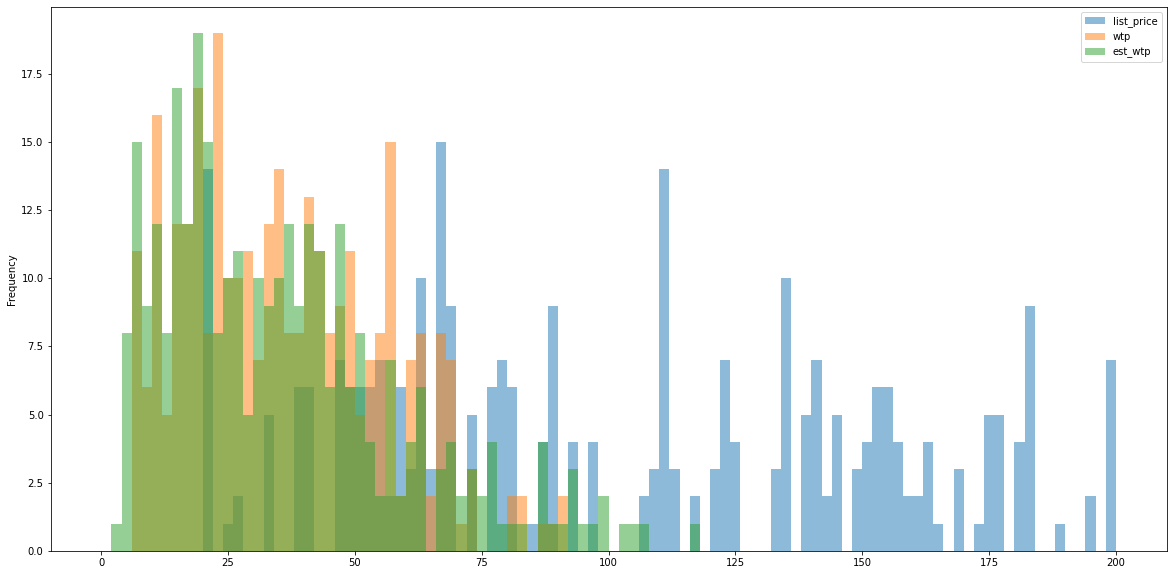

In [33]:
# Distribution of price-like variables
df[['list_price', 'wtp', 'est_wtp']].plot.hist(bins=100, alpha=0.5, figsize=(20,10), range=(0,200))

<AxesSubplot:xlabel='index', ylabel='price'>

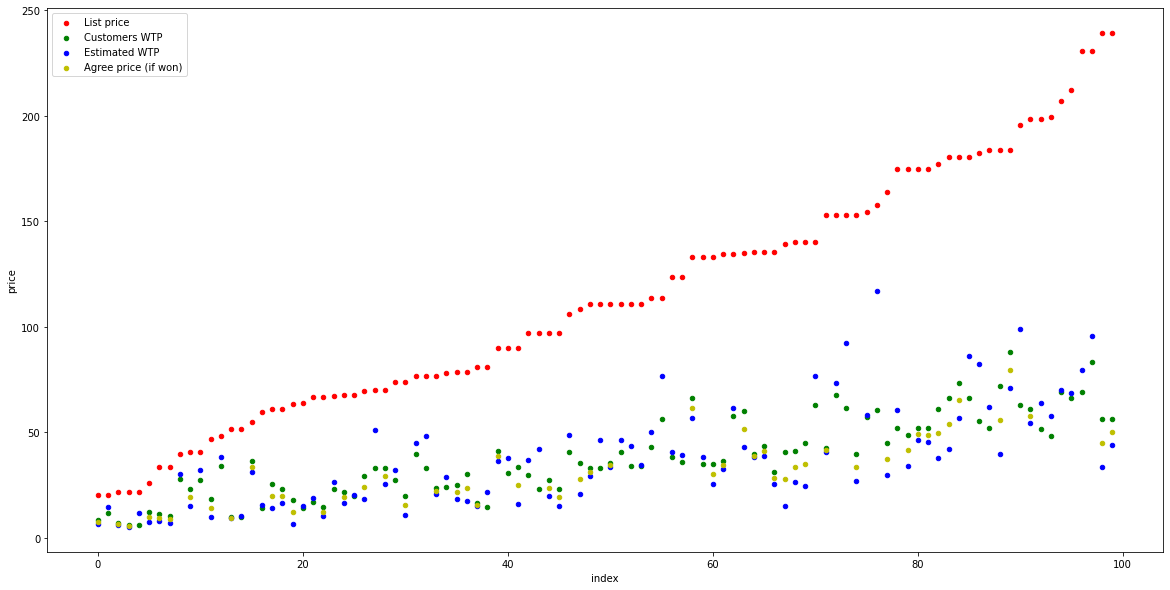

In [34]:
# Prices for random sample of quotes
examples = df.sample(100).sort_values(by='list_price').reset_index(drop=True).reset_index()
ax = examples.plot.scatter(x='index', y='list_price', color='r', label='List price', figsize=(20,10))
examples.plot.scatter(x='index', y='wtp', color='g', label='Customers WTP', ax=ax)
examples.plot.scatter(x='index', y='est_wtp', color='b', label='Estimated WTP', ax=ax)
examples.plot.scatter(x='index', y='price', color='y', label='Agree price (if won)', ax=ax)

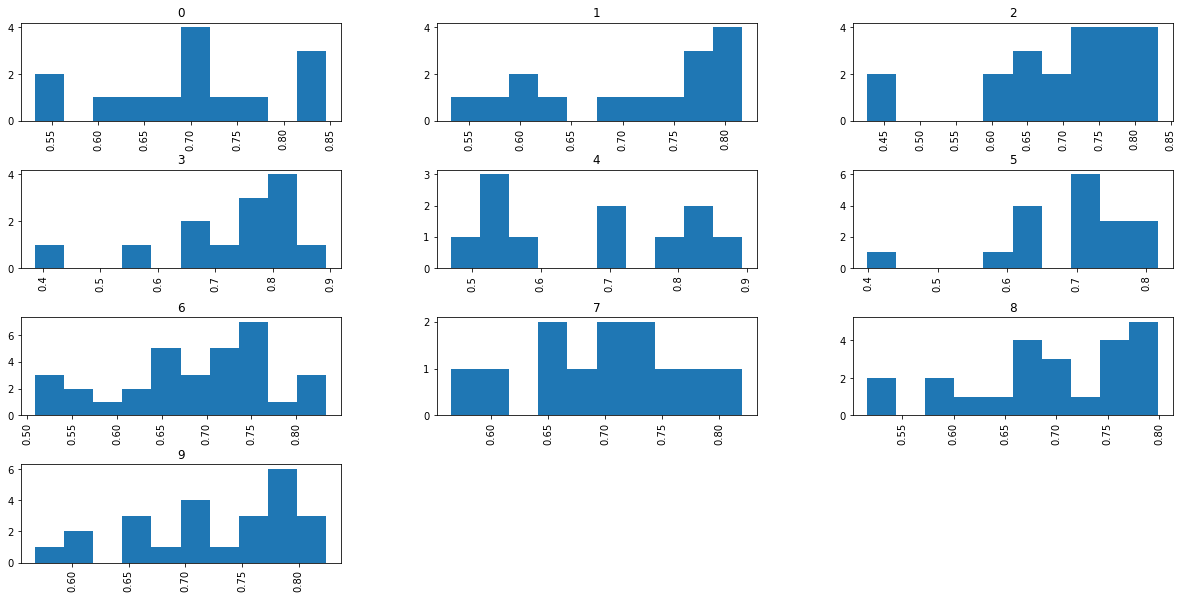

In [35]:
# Distribution of discounts on won deals by salesperson
df['discount'] = np.where(df['result']==1, 1 - df['price']/df['list_price'], np.nan)
_ = df['discount'].hist(by=df['salesperson'], figsize=(20,10))

### Analysis by salesperson

In [15]:
ss = df.reset_index().groupby('salesperson').agg({'index':'count', 'discount':'mean', 'result':'mean'
    , 'wtp':'sum', 'price':'sum', 'sales_wtp_bias':'mean', 'sales_wtp_uncertainty':'mean'})
ss['pct_wtp_captured'] = ss['price']/ss['wtp']
ss.to_csv('ss.csv')

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:78

Best number of neighbours: {'n_neighbors': 5}


Text(0, 0.5, 'wtp_uncertainty')

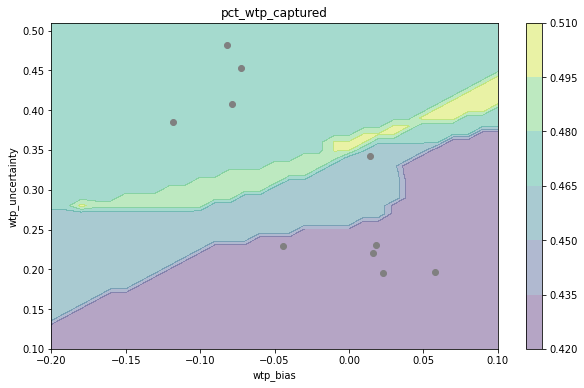

In [16]:
# Get data into numpy arrays
X=ss[['sales_wtp_bias','sales_wtp_uncertainty']].values
y=ss['pct_wtp_captured'].values.reshape(-1, 1)

# Train knn model
num_neigh = np.arange(5, 150, 10)
hyperparameters = dict(n_neighbors=num_neigh)
knr = KNeighborsRegressor()
tune_neigh = GridSearchCV(knr, hyperparameters, cv=10)
neigh = tune_neigh.fit(X,y)
print('Best number of neighbours: ' + str(tune_neigh.best_params_))

# Predict field over range of x1, x2
x1_values = np.arange(-0.2, 0.1, 0.01)
x2_values = np.arange(0.1, 0.52, 0.01)
xx1, xx2 = np.meshgrid(x1_values, x2_values)
X_pred = np.array([xx1.ravel(), xx2.ravel()]).T
z = neigh.predict(X_pred)

# Plot field and also show where individual points are
fig, ax = plt.subplots(figsize=(10,6))
cf = ax.contourf(xx1, xx2, z.reshape(xx1.shape), alpha = 0.4)#, norm=norm)
fig.colorbar(cf, ax=ax)
ax.scatter(x=X[:,0], y=X[:,1], c='grey')
ax.set_title('pct_wtp_captured')
ax.set_xlabel('wtp_bias')
ax.set_ylabel('wtp_uncertainty')

## Model

In [36]:
X = df[['customer', 'item',	'list_price', 'salesperson', 'item_quality']]
y = df[['result', 'price']]

In [83]:
def model(X, y=None):

    x_salesperson = jnp.array(X['salesperson'])
    x_item_quality = jnp.array(X['item_quality'])
    x_list_price = jnp.array(X['list_price'])
    x_customer = jnp.array(X['customer'])

    if y is not None:
        y_result = jnp.array(y['result'])
        y_price = jnp.array(y['price'])
    
    # Salespeople
    num_sales = X['salesperson'].nunique() # number of salespeople in data
    # prior on bias in salespersons estimate of customers wtp, a proportion of the wtp
    sales_wtp_bias_mean = numpyro.sample(
        "sales_wtp_bias_pct_mean",
        dist.Normal(-0.1,0.2)
    )
    sales_wtp_bias_sigma = numpyro.sample(
        "sales_wtp_bias_pct_sigma",
        dist.HalfNormal(0.2)
    )
    # a prior on the error on the salespersons estimate of the customers wtp, a proportion of the wtp
    sales_wtp_uncertainty_scale = numpyro.sample(
        "sales_wtp_uncertainty_pct_scale",
        dist.HalfNormal(0.2)
    )
    # sample salespeople
    with numpyro.plate('salespeople', num_sales):
        with numpyro.handlers.reparam(config={"sales_wtp_bias_pct": TransformReparam()}):
            sales_wtp_bias = numpyro.sample(
                "sales_wtp_bias_pct",
                dist.TransformedDistribution(
                    dist.Normal(loc=jnp.zeros((num_sales)), scale=1.0),
                    dist.transforms.AffineTransform(sales_wtp_bias_mean, sales_wtp_bias_sigma),
                ),
            )
        unscaled_sales_wtp_uncertainty = numpyro.sample(
            "unscaled_sales_wtp_uncertainty", 
            dist.HalfNormal(scale=jnp.ones(num_sales))
        )
        sales_wtp_uncertainty = numpyro.deterministic("sales_wtp_uncertainty_pct", sales_wtp_uncertainty_scale * unscaled_sales_wtp_uncertainty)
        #sales_wtp_uncertainty = numpyro.sample("sales_wtp_uncertainty_pct", dist.HalfNormal(scale=sales_wtp_uncertainty_scale))
        # with pyro.poutine.reparam(config={"sales_wtp_uncertainty_pct": TransformReparam()}):
        #     sales_wtp_uncertainty = pyro.sample(
        #         "sales_wtp_uncertainty_pct",
        #         dist.TransformedDistribution(
        #             dist.HalfNormal(scale=torch.ones((num_sales,))),
        #             dist.transforms.AffineTransform(0.0, sales_wtp_uncertainty_scale),
        #         ),
        #     )
        # with pyro.poutine.reparam(config={"sales_wtp_uncertainty_pct": LocScaleReparam()}):#centered=0)}):
        #     sales_wtp_uncertainty = pyro.sample(
        #         "sales_wtp_uncertainty_pct",
        #         dist.LogNormal(loc=0.0, scale=sales_wtp_uncertainty_scale).expand([num_sales,])
        #     )
    #print(sales_wtp_uncertainty_scale)
    #print(sales_wtp_uncertainty)


    #print('salespeople shapes: ', sales_wtp_bias.shape, sales_wtp_uncertainty.shape)

    # Customers
    num_cust= X['customer'].nunique()
    #num_cust = len(X) # number of customers (and rows) in data
    #print(num_cust)
    #prior_beta_quality_loc = pyro.distributions.Uniform(5,10) # prior of the mean of the coefficient of item quality in customers assessment of their wtp, £ per unit of quality
    #prior_beta_quality_scale = pyro.distributions.Uniform(1,2) # prior of the std deviation of the coefficient of item quality in customers assessment of their wtp, £ per unit of quality
    beta_quality_loc = numpyro.sample("beta_quality_loc", 
            dist.TransformedDistribution(
                dist.Uniform(5,15),
                dist.transforms.ExpTransform().inv
            )
    ) # sample mean betas from prior distribution
    beta_quality_scale = numpyro.sample("beta_quality_scale", 
        dist.InverseGamma(1, 1)
    )
    #print(beta_quality_loc, beta_quality_scale)
     # # sample std deviation of beta from prior distribution
    #print(beta_quality_loc, beta_quality_scale)
    #beta_quality = torch.distributions.LogNormal(beta_quality_loc, beta_quality_scale).sample([num_cust,])
    #print(beta_quality.shape)


    with numpyro.plate('customers', num_cust): #sample customers, all from same distribution for now
    #     with pyro.poutine.reparam(config={"beta_quality": TransformReparam()}):
    #         beta_quality = pyro.sample(
    #             "beta_quality",
    #             dist.TransformedDistribution(
    #                 dist.Normal(loc=torch.tensor(0.0), scale=torch.tensor(1.0)).expand([num_cust,]),
    #                 dist.transforms.AffineTransform(beta_quality_loc, beta_quality_scale),
    #             ),
    #         )

        # with pyro.poutine.reparam(config={"beta_quality": LocScaleReparam()}):#centered=0)}):
        #     beta_quality = pyro.sample(
        #         "beta_quality",
        #         dist.LogNormal(loc=beta_quality_loc, scale=beta_quality_scale).expand([num_cust,])
        #     )
        with numpyro.handlers.reparam(config={"beta_quality": LocScaleReparam(centered=0)}):
            beta_quality = numpyro.sample("beta_quality", dist.LogNormal(beta_quality_loc, beta_quality_scale).expand([num_cust,]))

    #print('customer params shape: ', beta_quality.shape)
    #print(x_item_quality.shape, beta_quality.shape, x_customer.shape, x_list_price.shape)
    #wtp = pyro.deterministic("wtp", torch.clamp(x_item_quality * beta_quality[x_customer], min=torch.ones_like(x_list_price), max=x_list_price))
    wtp_unbound = x_item_quality * beta_quality[x_customer]
    #print(wtp_unbound.shape)
    wtp = jnn.softplus(wtp_unbound)
    #print(wtp.shape)
    #print(wtp.shape, sales_wtp_uncertainty.shape, x_salesperson.shape)
    wtp_uncertainty = wtp * sales_wtp_uncertainty[x_salesperson]
    #print(wtp_uncertainty.shape)
    #print('wtp shapes: ', wtp.shape, wtp_uncertainty.shape)
    #print('shape of x_list_price:', x_list_price.shape)
    #print(wtp_uncertainty.min(), wtp.min(), sales_wtp_uncertainty[x_salesperson].min())
    #print(sales_wtp_uncertainty)
    #est_wtp = torch.clamp(
    #print(sales_wtp_bias.shape) 
    #print(x_salesperson.shape)
    #print(sales_wtp_bias[x_salesperson].shape)
    est_wtp_loc = wtp*(1.0+sales_wtp_bias[x_salesperson])
    # with numpyro.handlers.reparam(config={"estimated_wtp": LocScaleReparam(centered=0)}):
    #     est_wtp = numpyro.sample(
    #             "estimated_wtp",
    #             dist.TruncatedNormal(low=0.01, loc=est_wtp_loc, scale=wtp_uncertainty)
    #                 #numpyro.distributions.Normal(, y)
    #             )
        #), 
        #min=torch.ones_like(x_list_price), 
        #max=x_list_price
    #)
    with numpyro.handlers.reparam(config={"estimated_wtp": TransformReparam()}):
        est_wtp = numpyro.sample(
                "estimated_wtp",
                dist.TransformedDistribution(
                    dist.TruncatedNormal(low=0.01, loc=10., scale=jnp.ones_like(wtp_uncertainty)),
                    AffineTransform(est_wtp_loc - 10.0, wtp_uncertainty),
                )
        )



    #print('shape of est_wtp', est_wtp.shape)
    prob_win = jnp.where(wtp < est_wtp, jnp.zeros_like(x_list_price), jnp.ones_like(x_list_price))
    #prob_win = jnn.sigmoid(wtp - est_wtp)

    num_quotes = len(X)
    with numpyro.plate('negotiations', num_quotes):
        
        result = numpyro.sample("result", dist.Bernoulli(prob_win), obs = None if y is None else y_result)
        hidden_price = jnp.where(wtp < x_list_price, (est_wtp+wtp) /2, x_list_price)
        if y is not None:
            obs_mask = y_result == 1.0
            with mask(mask = obs_mask):
                price = numpyro.sample("price_if_won", numpyro.distributions.Normal(hidden_price, 0.01), obs = y_price)#[mask])#None if y is None else y_price)
                #price = pyro.sample("price_if_won", pyro.distributions.Delta(hidden_price), obs = y_price)#[mask])#None if y is None else y_price)
        else:
            price = numpyro.sample("price_if_won", numpyro.distributions.Normal(hidden_price, 0.01))

    #outcome[c] = {'item':i, 'result':result, 'price':hidden_price, 'list_price':list_price[i].item(), 'wtp':wtp.item(), 'est_wtp':est_wtp.item(), 'salesperson':s}

    return result, hidden_price, None if y is None else price

In [67]:
y_gen = handlers.seed(model, rng_key)(X,y)
y_gen[2]

DeviceArray([       nan,        nan, 52.001724 ,        nan,        nan,
             27.94006  ,        nan, 18.590326 , 43.893944 ,        nan,
             23.168257 ,        nan, 19.018633 ,        nan,        nan,
                    nan, 16.3447   , 51.188362 , 51.48985  , 19.016155 ,
             61.66629  , 58.39042  , 34.019585 ,        nan, 17.402737 ,
             26.62065  , 10.64511  , 38.416725 ,        nan, 76.980354 ,
                    nan, 61.310684 ,        nan, 32.989647 ,        nan,
                    nan,        nan,        nan,        nan,        nan,
                    nan,  6.9789305, 19.725883 ,        nan, 26.887081 ,
             50.16799  ,        nan, 36.102444 ,        nan,        nan,
             23.857943 ,        nan, 26.497066 , 49.41949  ,  6.4669046,
             37.144413 , 23.528776 ,        nan, 57.6401   , 53.938644 ,
              9.358982 ,        nan, 45.84755  , 49.783005 ,        nan,
             29.269165 , 45.309612 , 28.029972 , 17

In [72]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=200, num_samples=1000)
rng_key = random.PRNGKey(42)
mcmc.run(rng_key, X, y)
mcmc.print_summary()

sample: 100%|██████████| 1200/1200 [00:36<00:00, 32.90it/s, 1023 steps of size 8.19e-08. acc. prob=0.82]



                                       mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta_quality_decentered[0]      2.79      0.00      2.79      2.79      2.79      0.50      1.00
       beta_quality_decentered[1]      1.04      0.00      1.04      1.04      1.04      0.55      1.35
       beta_quality_decentered[2]      3.20      0.00      3.20      3.20      3.20      0.50      1.00
       beta_quality_decentered[3]      1.84      0.00      1.84      1.84      1.84      0.50      1.00
       beta_quality_decentered[4]      0.18      0.00      0.18      0.18      0.18      0.50      1.00
       beta_quality_decentered[5]      0.17      0.00      0.17      0.17      0.17      0.50      1.00
       beta_quality_decentered[6]      0.86      0.00      0.86      0.86      0.86      0.50      1.00
       beta_quality_decentered[7]      6.85      0.00      6.85      6.85      6.85      0.50      1.00
       beta_quality_decentered[8]      0.18      0.00      0.18

In [139]:
samples = mcmc.get_samples()
predictive = Predictive(model, samples, return_sites=['result', 'price_if_won'])
pred_y = predictive(rng_key, X)

In [142]:
idx = jnp.array([y['result']==1.0][0])
p = pred_y['price_if_won'].mean(axis=0)[idx]
t = jnp.array(y['price'])[idx]

print('R2: ', r2_score(t, p))
print('AUC: ', roc_auc_score(y['result'], pred_y['result'].mean(axis=0), multi_class='ovo'))


R2:  0.8012366233029157
AUC:  0.5035760205721633


In [73]:
samples.keys()

dict_keys(['beta_quality', 'beta_quality_decentered', 'beta_quality_loc', 'beta_quality_scale', 'estimated_wtp', 'estimated_wtp_base', 'sales_wtp_bias_pct', 'sales_wtp_bias_pct_base', 'sales_wtp_bias_pct_mean', 'sales_wtp_bias_pct_sigma', 'sales_wtp_uncertainty_pct', 'sales_wtp_uncertainty_pct_scale', 'unscaled_sales_wtp_uncertainty'])

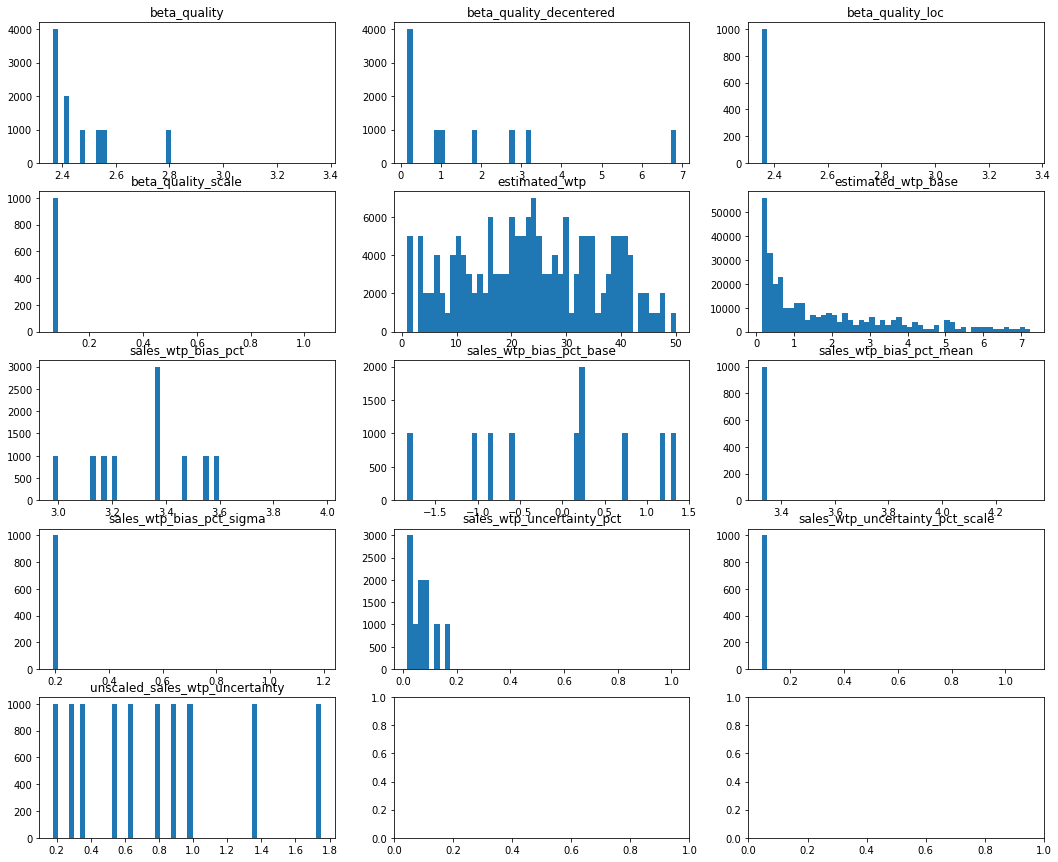

In [74]:
num_plots = len(samples.keys())
columns = 3
whole_rows, part_rows = divmod(num_plots, columns)
rows = whole_rows + int(part_rows>0)
fig,axs = plt.subplots(rows,columns, figsize=(18,15))
axs = axs.ravel()
for i, (site, data) in enumerate(samples.items()):
    axs[i].hist(jnp.ravel(data), bins = 50, range=(jnp.min(data), max(min(jnp.max(data),50),jnp.min(data)+1)))
    axs[i].set_title(site)


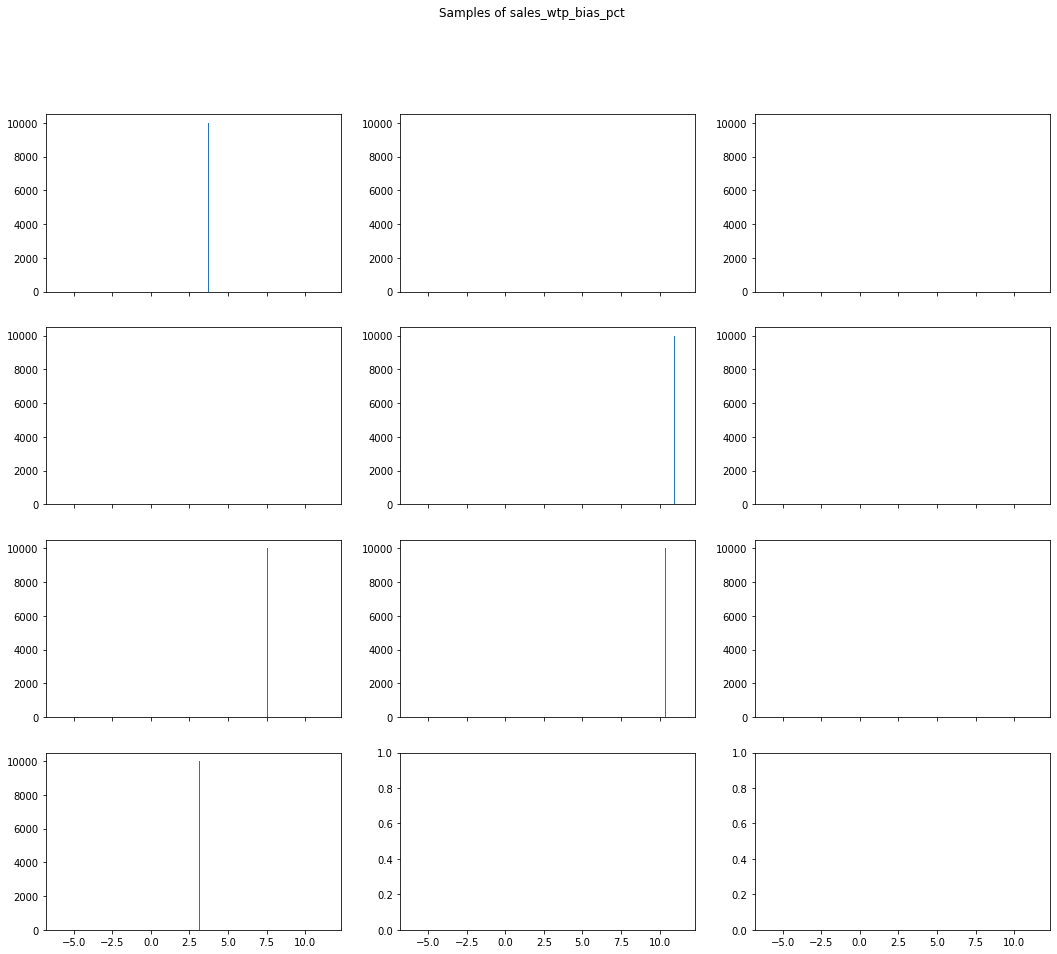

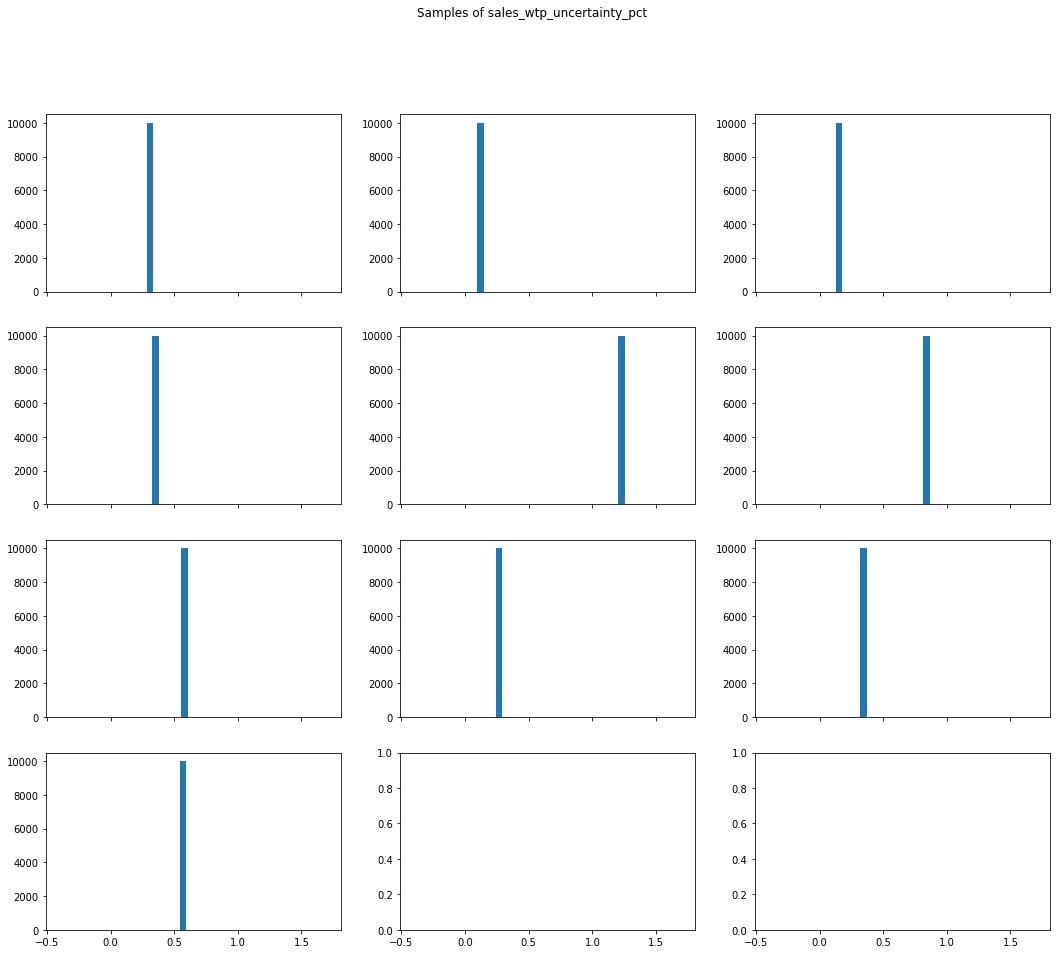

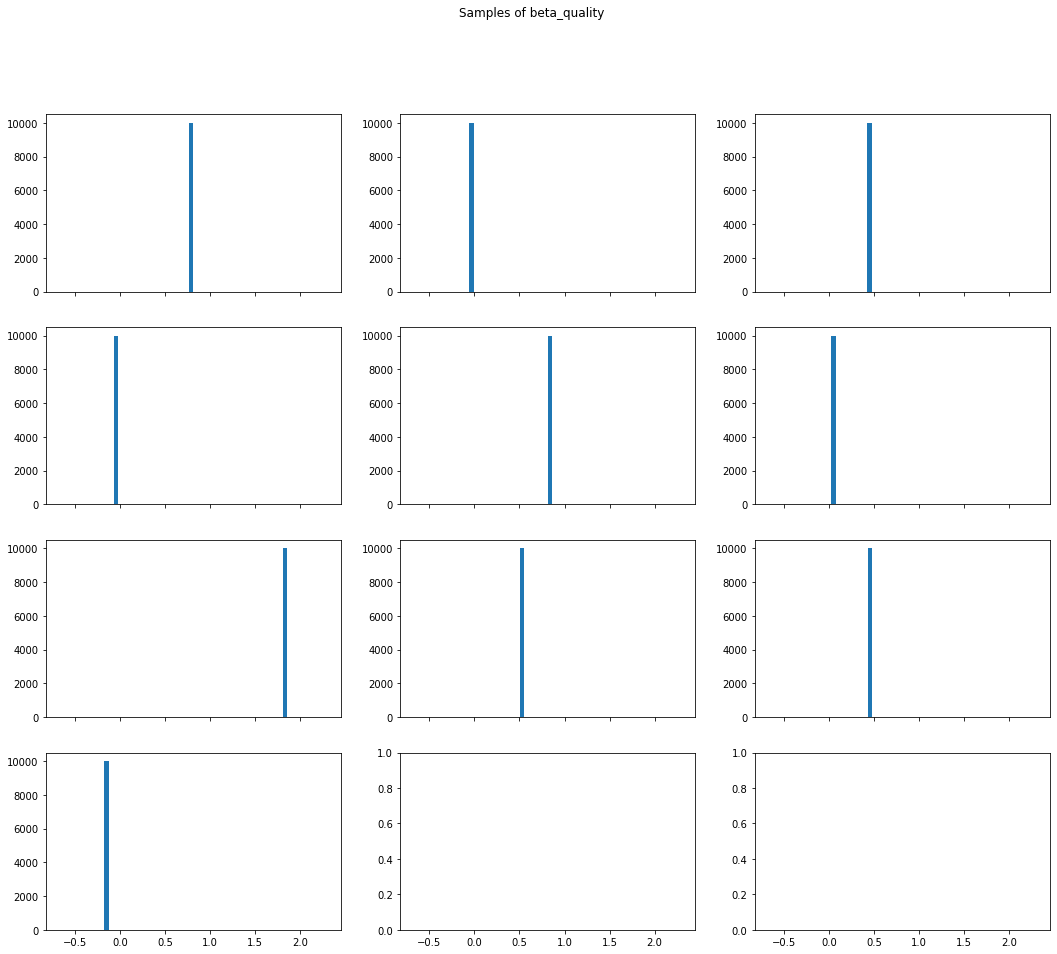

In [71]:
def plot_subsites(site):
    numplots = samples[site].shape[-1]
    columns = 3
    whole_rows, part_rows = divmod(numplots, columns)
    rows = whole_rows + int(part_rows>0)
    fig,axs = plt.subplots(rows,columns, figsize=(18,15), sharex=True)
    for i, ax in enumerate(axs.ravel()):
        if i < numplots:
            ax.hist(samples[site][:,i], bins = 20)
    plt.suptitle('Samples of ' + site)

plot_subsites('sales_wtp_bias_pct')
plot_subsites('sales_wtp_uncertainty_pct')
plot_subsites('beta_quality')
